# Tweet content categorization

In [ ]:
from tweetnlp import TopicClassification, Sentiment, Irony, Hate, Offensive, Emotion, NER
import pandas as pd
import plotly.graph_objects as go

topic_model = TopicClassification()
sentiment_model = Sentiment()
irony_model = Irony()
hate_model = Hate()
offensive_model = Offensive()
emotion_model = Emotion()
entity_model = NER()

## Visualization of the models result

In [8]:
class TweetAnalysisPlots:
    def update_layout(self, fig, title):
        fig.update_layout(
            title=title,
            xaxis_title='Labels',
            yaxis_title='Probabilities',
            yaxis_range=[0, 1],
            font=dict(size=14),
            margin=dict(l=40, r=40, t=60, b=80)
        )
        
    def plot_probabilities(self, title, data):
        probabilities = data['probability']
        fig = go.Figure([go.Bar(x=list(probabilities.keys()), y=list(probabilities.values()))])
        self.update_layout(fig, title)
        fig.show()
        fig.write_image(f'resources/{title}.png')


    # Function to create a combined bar chart
    def plot_combined_probabilities(self, title, data, xlabel='Labels', ylabel='Probabilities'):
        fig = go.Figure([go.Bar(x=list(data.keys()), y=list(data.values()))])
        self.update_layout(fig, title)
        fig.show()
        fig.write_image(f'resources/{title}.png')
        
    def run(self, tweet):
        self.plot_probabilities('Topic Classification Probabilities', topic_model.topic(tweet, return_probability=True))
        self.plot_probabilities('Sentiment Probabilities', sentiment_model.sentiment(tweet, return_probability=True))
        self.plot_probabilities('Emotion Probabilities', emotion_model.emotion(tweet, return_probability=True))

        combined_probs = {
            'Irony': irony_model.irony(tweet, return_probability=True)['probability']['irony'],
            'Hate': hate_model.hate(tweet, return_probability=True)['probability']['HATE'],
            'Offensive': offensive_model.offensive(tweet, return_probability=True)['probability']['offensive']
        }
        self.plot_combined_probabilities('Irony, Hate, Offensive Probabilities', combined_probs)
        
        ner_results = entity_model.ner(tweet, return_probability=True)
        ner_probs = {'probability': {f"{result['type']}: {result['entity']}": result['probability'] for result in ner_results}}
        self.plot_probabilities('Entity Identification', ner_probs)

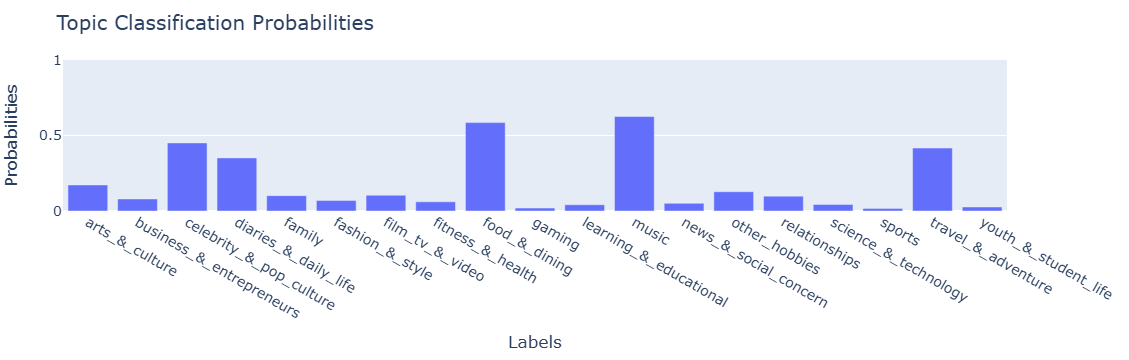

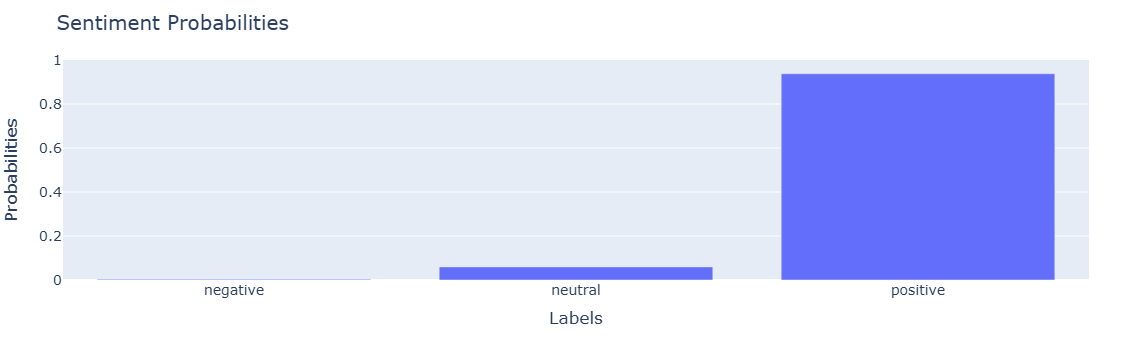

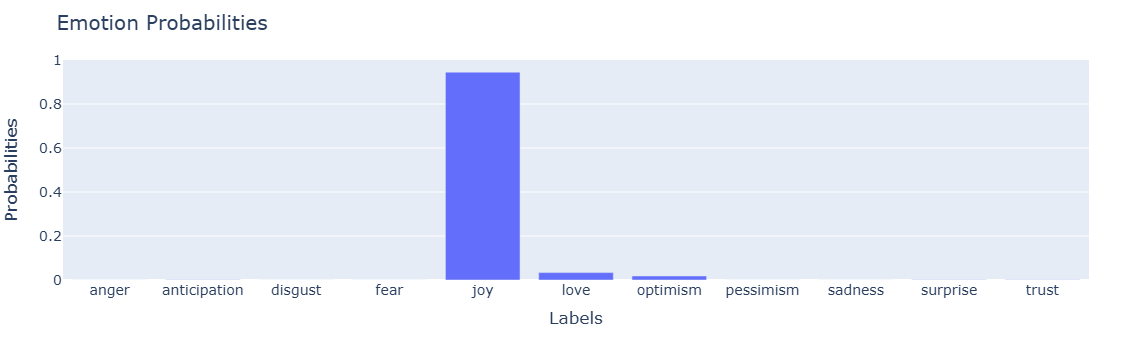

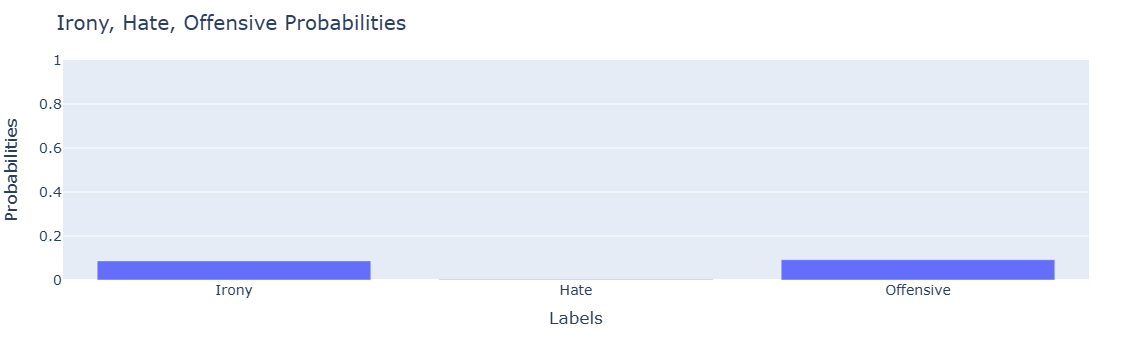

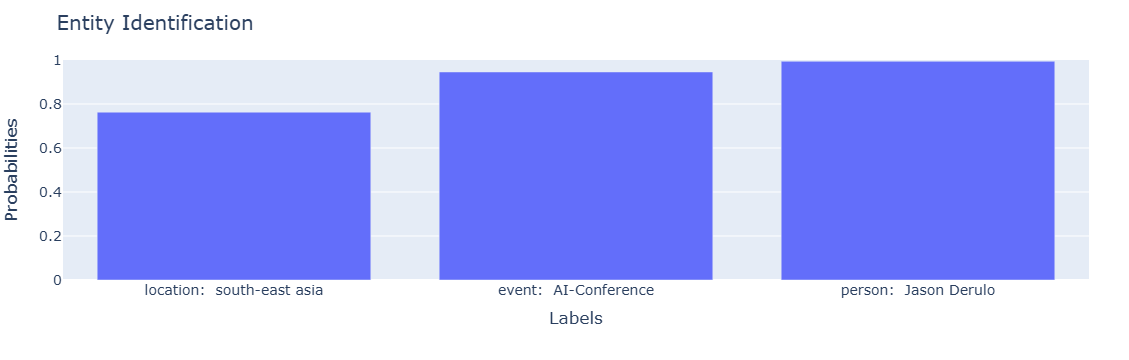

In [9]:
tweetanalysisplots = TweetAnalysisPlots()

tweet="I would love to go to south-east asia, travel, eat some good meals, go the the AI-Conference and meet Jason Derulo"
tweetanalysisplots.run(tweet)

## Generate a report for multiple tweets

In [10]:
import pandas as pd

class TweetAnalysis:
    def __init__(self, prob_th=0.1):
        self.data = []
        self.th = prob_th
    
    def extract_probabilities(self, tweet):
        # Extract probabilities from each model and round to two decimal places
        topic_probs = {k: round(v, 2) for k, v in topic_model.topic(tweet, return_probability=True)['probability'].items() if v >= self.th}
        sentiment_probs = {k: round(v, 2) for k, v in sentiment_model.sentiment(tweet, return_probability=True)['probability'].items() if v >= self.th}
        emotion_probs = {k: round(v, 2) for k, v in emotion_model.emotion(tweet, return_probability=True)['probability'].items() if v >= self.th}
        irony_prob = round(irony_model.irony(tweet, return_probability=True)['probability']['irony'], 2)
        hate_prob = round(hate_model.hate(tweet, return_probability=True)['probability']['HATE'], 2)
        offensive_prob = round(offensive_model.offensive(tweet, return_probability=True)['probability']['offensive'], 2)
        
        # Extract NER results with probabilities
        ner_results = entity_model.ner(tweet, return_probability=True)
        ner_probs = {f"{result['type']}:{result['entity']}": round(result['probability'], 2) for result in ner_results if result['probability'] >= self.th}
        
        return {
            'topic_probs': topic_probs,
            'sentiment_probs': sentiment_probs,
            'emotion_probs': emotion_probs,
            'irony_prob': irony_prob,
            'hate_prob': hate_prob,
            'offensive_prob': offensive_prob,
            'ner_probs': ner_probs
        }
    
    def analyze_tweets(self, tweets):
        for user_id, tweet in tweets:
            probabilities = self.extract_probabilities(tweet)
            probabilities['user_ID'] = user_id
            probabilities['tweet'] = tweet
            self.data.append(probabilities)
    
    def save_to_csv(self, filename):
        df = pd.DataFrame(self.data)
        df.set_index(['user_ID', 'tweet'], inplace=True)
        display(df)
        df.to_csv(filename)

In [11]:
# Define the data
data = [
    [1, "Just saw the most amazing sunset today! The sky was a blend of orange, pink, and purple. It felt like a painting. #blessed #sunset"],
    [2, "Can't believe how fast this year is going by. It feels like just yesterday we were celebrating New Year's. Time really does fly!"],
    [3, "Anyone have any good book recommendations? I'm into mysteries and thrillers, but I'm open to anything that's a page-turner!"],
    [4, "Loving the new features in the latest software update! The user interface is so much smoother and the new tools are super handy. Great job, dev team!"],
    [5, "Had a great workout this morning. Feeling pumped! Started with some cardio, then moved on to weight training. Consistency is key!"],
    [6, "Excited for the weekend. Any plans, folks? I'm thinking of going hiking if the weather holds up. Nature is the best escape."],
    [7, "Cooking up a storm in the kitchen tonight. Trying out a new recipe for pasta with homemade sauce. Wish me luck! #foodie #cooking"],
    [8, "Really enjoyed the movie I watched last night. The plot was gripping, and the acting was top-notch. Highly recommend it to anyone looking for a good film!"],
    [9, "Thinking about starting a new hobby. Any suggestions? I've been considering learning to play the guitar or maybe taking up painting. Something creative!"],
    [10, "Feeling grateful for all the support from my friends and family. Their encouragement means the world to me. Always appreciate your loved ones. #gratitude"]
]

# Create a DataFrame
df = pd.DataFrame(data, columns=['user_ID', 'tweet'])

# Analyze tweets and save to CSV
tweet_analysis = TweetAnalysis(prob_th=0.1)
tweet_analysis.analyze_tweets(df.values.tolist())
tweet_analysis.save_to_csv('resources/tweet_analysis.csv')

,,topic_probs,sentiment_probs,emotion_probs,irony_prob,hate_prob,offensive_prob,ner_probs
user_ID,tweet,,,,,,,
1,"Just saw the most amazing sunset today! The sky was a blend of orange, pink, and purple. It felt like a painting. #blessed #sunset","{'diaries_&_daily_life': 0.34, 'other_hobbies'...",{'positive': 0.99},{'joy': 0.93},0.15,0.0,0.04,{}
2,Can't believe how fast this year is going by. It feels like just yesterday we were celebrating New Year's. Time really does fly!,"{'diaries_&_daily_life': 0.88, 'family': 0.22,...",{'positive': 0.96},{'joy': 0.95},0.26,0.0,0.14,{'event: New Year's': 0.97}
3,"Anyone have any good book recommendations? I'm into mysteries and thrillers, but I'm open to anything that's a page-turner!","{'arts_&_culture': 0.49, 'diaries_&_daily_life...",{'positive': 0.9},"{'anticipation': 0.35, 'joy': 0.4, 'optimism':...",0.03,0.0,0.06,{}
4,"Loving the new features in the latest software update! The user interface is so much smoother and the new tools are super handy. Great job, dev team!","{'business_&_entrepreneurs': 0.12, 'science_&_...",{'positive': 0.99},{'joy': 0.96},0.59,0.0,0.04,{}
5,"Had a great workout this morning. Feeling pumped! Started with some cardio, then moved on to weight training. Consistency is key!","{'diaries_&_daily_life': 0.16, 'fitness_&_heal...",{'positive': 0.98},"{'joy': 0.87, 'optimism': 0.12}",0.07,0.0,0.08,{}
6,"Excited for the weekend. Any plans, folks? I'm thinking of going hiking if the weather holds up. Nature is the best escape.","{'diaries_&_daily_life': 0.55, 'news_&_social_...",{'positive': 0.99},"{'joy': 0.72, 'optimism': 0.23}",0.04,0.0,0.05,{}
7,Cooking up a storm in the kitchen tonight. Trying out a new recipe for pasta with homemade sauce. Wish me luck! #foodie #cooking,"{'diaries_&_daily_life': 0.18, 'family': 0.11,...",{'positive': 0.94},{'joy': 0.86},0.03,0.0,0.07,{}
8,"Really enjoyed the movie I watched last night. The plot was gripping, and the acting was top-notch. Highly recommend it to anyone looking for a good film!","{'diaries_&_daily_life': 0.17, 'film_tv_&_vide...",{'positive': 0.99},{'joy': 0.93},0.03,0.0,0.07,{}
9,Thinking about starting a new hobby. Any suggestions? I've been considering learning to play the guitar or maybe taking up painting. Something creative!,"{'arts_&_culture': 0.13, 'diaries_&_daily_life...","{'neutral': 0.31, 'positive': 0.68}","{'joy': 0.54, 'optimism': 0.33}",0.03,0.0,0.07,{}
